# HSMA 3C: Exercise 3 - Getting travel times from an API

*The first cell only needs to be run if running in colab!* 

In [ ]:
!git clone https://github.com/hsma-programme/h6_3c_interactive_plots_travel.git
%cd /content/h6_3c_interactive_plots_travel/h6_3c_interactive_plots_travel/exercises_colab
!pip install contextily
!pip install routingpy

## Extension

Import the required packages.

In [23]:
import geopandas
import pandas as pd
import matplotlib.pyplot as plt
import routingpy as rp
import contextily as cx

### Getting and plotting travel time matrices

The code below will 
- create a dataframe of the population-weighted centroids of York and Hull
- create a dataframe of the LSOA boundaries of York and Hull
- create a map showing the LSOA boundaries of York and Hull with the population-weighted centroids of each LSOA

First, read through this code and try to understand what it is doing.

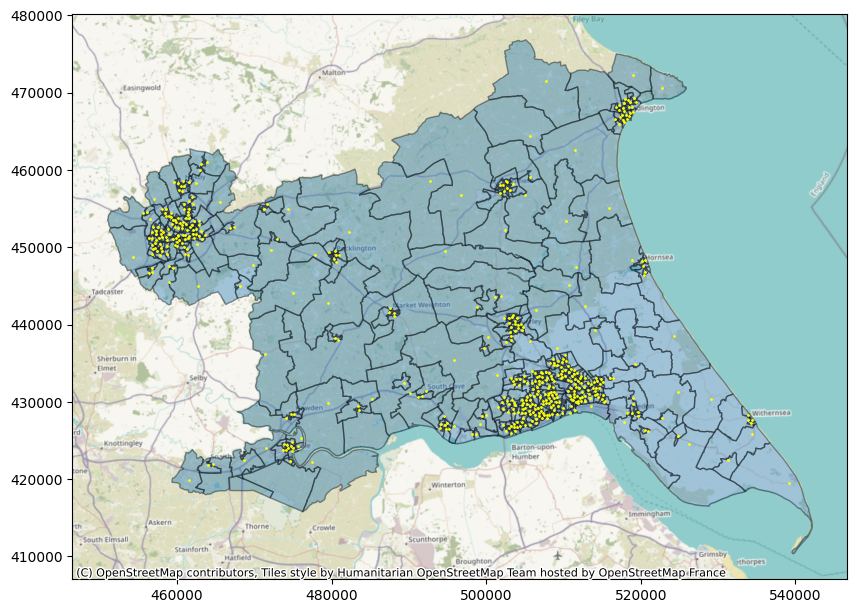

In [6]:
lsoa_centroids_2021 = pd.merge(
    geopandas.read_file("../datasets/exercises_2_and_3/LSOA_Dec_2021_PWC_for_England_Wales_2022.geojson"),
    geopandas.read_file("../datasets/exercises_2_and_3/Lower_layer_Super_Output_Areas_2021_EW_BGC_V3.geojson")[["LSOA21CD", "LSOA21NM"]],
    left_on="LSOA21CD",
    right_on="LSOA21CD"
).sort_values('LSOA21NM')

lsoa_centroids_2021_york = lsoa_centroids_2021[lsoa_centroids_2021["LSOA21NM"].str.contains("York|Hull")]

lsoa_boundaries_2021 = geopandas.read_file("../datasets/exercises_2_and_3/Lower_layer_Super_Output_Areas_2021_EW_BGC_V3.geojson")
lsoa_boundaries_2021_york = lsoa_boundaries_2021[lsoa_boundaries_2021["LSOA21NM"].str.contains("York|Hull")]

ax = lsoa_boundaries_2021_york.plot(alpha=0.4, edgecolor='black', figsize=(10,8))
lsoa_centroids_2021_york.plot(color="yellow", ax=ax, markersize=1)

cx.add_basemap(ax, crs=lsoa_boundaries_2021_york.crs.to_string(), zoom=10)

#### Getting the data into the right format for routingpy

Load in the potential clinic locations from **york_clinics_4.csv**.

In [7]:
york_clinic_locations = pd.read_csv("../datasets/exercises_2_and_3/york_clinics_4.csv")

Convert the centroids in `lsoa_centroids_2021_york` from EPSG:27700 (northings/eastings) to EPSG:4326 (lat/long) as this is the right format for the routingpy service.

Hint: the **to_crs** method will do what you need here!

In [10]:
lsoa_centroids_2021_3857 = lsoa_centroids_2021_york.to_crs('EPSG:4326')
lsoa_centroids_2021_3857

,FID,LSOA21CD,GlobalID,geometry,LSOA21NM
35118,35119,E01012933,bbbe8f77-31ec-4c63-a3bd-be80516c601a,POINT (-0.18083 54.13235),East Riding of Yorkshire 001A
32050,32051,E01012934,e1227942-0d8b-4a48-a6cb-343c978a777b,POINT (-0.20954 54.09775),East Riding of Yorkshire 001B
32956,32957,E01012939,4a4d05e5-a6b9-4a78-86b2-8a55320767f0,POINT (-0.17942 54.10604),East Riding of Yorkshire 001D
28351,28352,E01012940,ff19339c-d111-4dcb-83ac-619c6a9e4829,POINT (-0.18836 54.10175),East Riding of Yorkshire 001E
28385,28386,E01012941,73d8b5e0-0483-470e-a975-3dbbcbb8e2e2,POINT (-0.19940 54.10030),East Riding of Yorkshire 001F
...,...,...,...,...,...
31428,31429,E01013341,96bfa39e-6f21-4189-aba2-3bb5c8160812,POINT (-1.09623 53.91888),York 024B
29552,29553,E01013342,5fbc1f90-cb5e-4f3f-9169-5c125b114bc7,POINT (-1.10478 53.90278),York 024C
31521,31522,E01013423,bb247b55-e0fb-4cc2-9fd7-031cc162e128,POINT (-1.13760 53.91920),York 024D
29762,29763,E01013424,d391e218-c913-44ec-81a4-3848bcd1cd07,POINT (-1.14297 53.91266),York 024E


Use **zip** on the geometry column to pull out pairs of *source* coordinates (source = our LSOA centroids - where potential patients will come from)

HINT: Remember that routingpy expects the **longitude** before the **latitude**. 

In [11]:
source_coord_pairs = list(
    zip(lsoa_centroids_2021_3857.geometry.x,
    lsoa_centroids_2021_3857.geometry.y)
    )

source_coord_pairs

[(-0.18083406747253766, 54.132351635882046),
 (-0.2095376615688171, 54.09775018217785),
 (-0.17941687470129483, 54.10603509524728),
 (-0.1883573168704755, 54.10174663285468),
 (-0.19939850272961424, 54.1003049801294),
 (-0.1983096428414969, 54.105283908479336),
 (-0.1915246783367147, 54.1035655227972),
 (-0.2001384896072137, 54.09154286000609),
 (-0.19093515388569254, 54.09516286042208),
 (-0.18339073408421036, 54.09489941776692),
 (-0.1231138553814106, 54.11614785304812),
 (-0.17556489343598738, 54.10160672446734),
 (-0.21482005633887225, 54.09545196545205),
 (-0.2012922833570284, 54.094203706128994),
 (-0.2100254333249237, 54.09175798259245),
 (-0.2181107759298992, 54.081656491129564),
 (-0.20819008982956935, 54.084631527119384),
 (-0.18254875355420935, 54.08987224684585),
 (-0.20387418505292257, 54.08693312796991),
 (-0.19619279715788832, 54.08675367315768),
 (-0.1883820402951416, 54.08860111530134),
 (-0.1895078945705478, 54.08552751830753),
 (-0.20257928581356455, 54.0805547700677

The output of this will give you a list of tuples. 

Now turn these tuples into lists using a list comprehension. 

In [12]:
source_coord_pairs_list = [list(coord_tuple) for coord_tuple in source_coord_pairs]

Repeat the steps above, but this time for the data in **york_clinic_locations**.

Remember - york clinic locations is a standard pandas dataframe at this point - not a geodataframe.

You either need to convert it to a geodataframe first, or write your code very slightly differently.

In [15]:
destination_coord_pairs = list(
    zip(york_clinic_locations.longitude,
    york_clinic_locations.latitude)
    )

destination_coord_pairs_list  = [list(coord_tuple) for coord_tuple in destination_coord_pairs]

destination_coord_pairs_list

[[-1.1441219260327131, 53.944153462581],
 [-1.0735701866642375, 53.94789793032976],
 [-0.191791186470214, 54.09705414156359],
 [-0.4239582729613501, 53.84608140601469]]

Join the two lists into one. 

In [17]:
all_coordinates = []

all_coordinates.extend(source_coord_pairs_list)
all_coordinates.extend(destination_coord_pairs_list)

all_coordinates

[[-0.18083406747253766, 54.132351635882046],
 [-0.2095376615688171, 54.09775018217785],
 [-0.17941687470129483, 54.10603509524728],
 [-0.1883573168704755, 54.10174663285468],
 [-0.19939850272961424, 54.1003049801294],
 [-0.1983096428414969, 54.105283908479336],
 [-0.1915246783367147, 54.1035655227972],
 [-0.2001384896072137, 54.09154286000609],
 [-0.19093515388569254, 54.09516286042208],
 [-0.18339073408421036, 54.09489941776692],
 [-0.1231138553814106, 54.11614785304812],
 [-0.17556489343598738, 54.10160672446734],
 [-0.21482005633887225, 54.09545196545205],
 [-0.2012922833570284, 54.094203706128994],
 [-0.2100254333249237, 54.09175798259245],
 [-0.2181107759298992, 54.081656491129564],
 [-0.20819008982956935, 54.084631527119384],
 [-0.18254875355420935, 54.08987224684585],
 [-0.20387418505292257, 54.08693312796991],
 [-0.19619279715788832, 54.08675367315768],
 [-0.1883820402951416, 54.08860111530134],
 [-0.1895078945705478, 54.08552751830753],
 [-0.20257928581356455, 54.0805547700677

Use a list comprehension to create a list that shows the locations of the coordinates relating to our **sources**.

In [26]:
source_indices = [i for i in range(len(source_coord_pairs_list))]

Use a list comprehension to create a list that shows the locations of the coordinates relating to our **destinations**.

In [27]:
destination_indices = [i for i in range(len(source_coord_pairs_list), len(all_coordinates))]

### Using routingpy

Set up routingpy.

You will need to set up an account on the openroute service here: https://openrouteservice.org/

In [24]:
ors_api_key = "5b3ce3597851110001cf6248282e2fc33c7e4b428a9b731f8ebb1f9b"

ors_api = rp.ORS(api_key=ors_api_key)

Request the data back from routingpy.

In [28]:
travel_matrix_york_4_clinics = ors_api.matrix(
    locations = all_coordinates,
    profile='driving-car',
    sources=source_indices,
    destinations=destination_indices,
    metrics=["distance", "duration"]
)

Take a look at the **durations** attribute of our matrix.

In [29]:
travel_matrix_york_4_clinics.durations

[[4180.58, 4216.15, 434.06, 2625.67],
 [3813.42, 3840.2, 228.09, 2270.48],
 [4063.34, 4090.12, 281.13, 2495.05],
 [3996.74, 4023.51, 214.52, 2428.45],
 [4001.45, 4028.22, 246.13, 2437.74],
 [3965.88, 3992.65, 210.56, 2402.17],
 [3997.42, 4024.19, 242.1, 2433.71],
 [3929.58, 3956.35, 191.75, 2267.17],
 [3932.07, 3958.84, 55.19, 2366.4],
 [3995.12, 4021.89, 146.12, 2304.3],
 [4331.94, 4358.71, 549.72, 2763.65],
 [4109.02, 4135.8, 326.81, 2540.73],
 [3997.97, 4024.74, 412.63, 2455.02],
 [3927.71, 3954.49, 207.03, 2298.88],
 [3833.05, 3859.83, 257.27, 2252.34],
 [3640.88, 3667.66, 417.42, 2106.97],
 [3734.93, 3761.71, 391.73, 2104.09],
 [3972.95, 3999.73, 188.63, 2273.87],
 [3792.77, 3819.55, 285.61, 2126.12],
 [3839.7, 3866.48, 295.18, 2140.62],
 [3872.4, 3899.18, 196.21, 2173.32],
 [3865.15, 3891.93, 243.88, 2166.07],
 [3772.37, 3799.15, 328.04, 2029.51],
 [3804.29, 3831.06, 318.92, 2105.2],
 [3819.85, 3846.63, 380.14, 2062.87],
 [3798.57, 3825.35, 428.77, 2019.72],
 [3745.15, 3771.93, 1

Convert this to a dataframe.

In [43]:
york_4_clinics_travel_df = pd.DataFrame(
    travel_matrix_york_4_clinics.durations,
    columns = [f"Site {i+1}" for i in range(len(destination_indices))],
    index = lsoa_centroids_2021_3857.LSOA21CD
)

york_4_clinics_travel_df

,Site 1,Site 2,Site 3,Site 4
LSOA21CD,,,,
E01012933,4180.58,4216.15,434.06,2625.67
E01012934,3813.42,3840.20,228.09,2270.48
E01012939,4063.34,4090.12,281.13,2495.05
E01012940,3996.74,4023.51,214.52,2428.45
E01012941,4001.45,4028.22,246.13,2437.74
...,...,...,...,...
E01013341,560.41,769.89,4053.03,3328.51
E01013342,522.92,832.66,4115.80,3391.28
E01013423,246.13,654.08,3937.22,3212.71


Work out the shortest travel time for each location. 

Remember: the results will be in seconds, not minutes.  

In [44]:
york_4_clinics_travel_df['shortest_minutes'] = york_4_clinics_travel_df.min(axis=1)

# change everything to minutes
york_4_clinics_travel_df = york_4_clinics_travel_df/60

york_4_clinics_travel_df

,Site 1,Site 2,Site 3,Site 4,shortest_minutes
LSOA21CD,,,,,
E01012933,69.676333,70.269167,7.234333,43.761167,7.234333
E01012934,63.557000,64.003333,3.801500,37.841333,3.801500
E01012939,67.722333,68.168667,4.685500,41.584167,4.685500
E01012940,66.612333,67.058500,3.575333,40.474167,3.575333
E01012941,66.690833,67.137000,4.102167,40.629000,4.102167
...,...,...,...,...,...
E01013341,9.340167,12.831500,67.550500,55.475167,9.340167
E01013342,8.715333,13.877667,68.596667,56.521333,8.715333
E01013423,4.102167,10.901333,65.620333,53.545167,4.102167


Create either a static or interactive plot (whichever you would prefer to have some more practice with!) 
- showing the LSOAs, coloured by travel time
- showing the clinic sites

If making a static plot, label each site with its name (Clinic 1, Clinic 2, Clinic 3, Clinic 4).

If making an interactive plot, set the clinic names as tooltips for the markers.

Hint: you don't have a geodataframe at this point! Join it back up with `lsoa_boundaries_2021_york`. 

You may want to run the `.reset_index()` method on `york_4_clinics_travel_df` to make it easier to join. 

Text(0.5, 1.0, 'Travel time to Proposed York Sites')

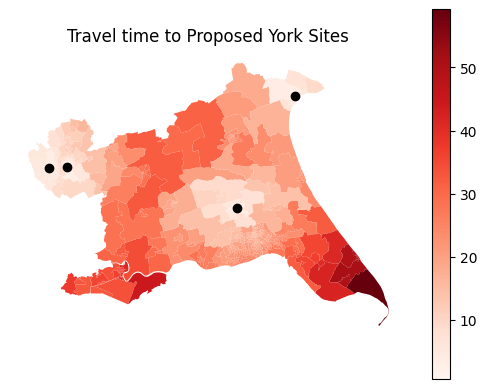

In [57]:
york_travel_gdf = pd.merge(lsoa_boundaries_2021_york , york_4_clinics_travel_df.reset_index())

ax = york_travel_gdf.plot(
    column='shortest_minutes',
    legend=True,
    cmap="Reds")

clinic_loc_gdf = geopandas.GeoDataFrame(
    york_clinic_locations,
    geometry=geopandas.points_from_xy(york_clinic_locations['longitude'], york_clinic_locations['latitude']),
    crs='EPSG:4326'
).to_crs('EPSG:27700')

clinic_loc_gdf.plot(ax=ax, color="black")

ax.axis('off')

plt.title("Travel time to Proposed York Sites")

## Challenge: Bonus Exercises

### 1. Getting and plotting isochrone data

Take a look at the slides on making isochrones at the following link.

[LINK](https://docs.google.com/presentation/d/1WnSsaT_0cNFp4W4Q0YVlXCTzyLcPVIvt3VMtwTrU9O4/edit?usp=sharing)

Load the additional requried libraries for this step.

In [ ]:
from shapely.geometry import Polygon

Create an isochrone map for the first clinic in the clinic list for 5, 10 and 15 minutes on foot.

In [ ]:
# No solution given

Write a for loop to generate isochrone maps for all four clinics.

In [ ]:
# No solution given

Plot the four isochrone maps in separate subplots using matplotlib.

In [ ]:
# No solution given

Plot the four isochrone maps on the same static (matplotlib) plot.

In [ ]:
# No solution given

### 2. Making multiple requests to the ORS API

In the datasets folder is another file called **york_clinics_9.csv**.

However, requesting the data for 9 clinics means we will exceed the number of requests you can make to the routingpy API at once. A matrix request can be up to 50 x 50 (2500 pairs) or any other combination that produces <= 2500 results (e.g. 250 sources and 10 destinations, 2500 sources and 1 destination, 1250 sources and 2 destinations)

Think about how you could split up your requests in such a way that you can get all of the required travel times. 

Once you have done this, create a new plot showing the travel times.

In [ ]:
# No solution given

Try comparing the average travel time across the region with 4 and 9 clinics. 

In [ ]:
# No solution given

### 3. Making interactive isochrone maps

Investigate whether it is possible to display the isochrone data using Folium. 

In [ ]:
# No solution given